### XGBoost

Dimensionality Reduction / Feature Selection

In [1]:
#importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v3.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [15]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(np.unique(y_train.astype(int))))
#dictionary of labels 
labels = dict(zip(numbers,letters))

From the initial modeling results for this dataset, the normal (not reduced to images of edges) re-scaled using standardization produced the best results. As a result, standardized normal images will be used for the remainder of this notebook.

In [ ]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = sc.transform(X_train.reshape(X_train.shape[0],-1))
X_test = sc.transform(X_test.reshape(X_test.shape[0],-1))

Dimensionality reduction is an important step in the Data Science pipeline because it reduces the complexity of the model by reducing the number of input features. This results in a decreased likelihood for the model to overfit on the training data. Additionally, removing noise and unimportant/redundant features can lead to better performing models. Lastly, reducing dimensionality will decrease the computational and memory requirements to train and use the model. 

Linear Discriminant Analysis is a linear supervised learning algorithm used for classification tasks by projecting the data to a lower dimensionality that maximizes the separation between classes. This is achieved by finding the vectors in the feature space that best separates the different classes of the data and minimizes the variance of the data within each class. 

In [ ]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [ ]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

Plotting components 1 and 2 from the LDA computation, it is observed that it does reasonably well at separating certain letters from others. For example, X and Y is separated well from the other letters using the first two linear discriminants. The other letters likely require more components to result in a clearer separation between the classes.

Hyperparameter tuning is an important step in modeling, where the values chosen for a model's hyperparameters can drastically change the performance of the model. Grid Search CV and Randomized Grid Search are methods to find the optimal values that results in the best performing model. 

Grud Search is an exhaustive search algorithm that tries every combination of each set of hyperparameters, and determines which results in the best model. Randomized Grid Search randomly chooses combinations of hyperarameters, which results in less computational requirments but does not guarantee the best performing model is found. However, with a sufficiently high n_iter value, it is likely a close to best performing model is found. 

For this investigation, randomized search will be used. 

#### Modeling with XGboost
XGBoost (Extreme Gradient Boosting) is a powerful and widely used gradient boosting algorithm that is particularly well-suited for dealing with large datasets. It is based on the concept of ensemble learning, where multiple weak learners (decision trees) are combined to create a strong learner that can make accurate predictions. XGBoost is known for its speed, scalability, and ability to handle missing values and outliers. It has become a popular choice in various machine learning competitions and is widely used in industry for a wide range of applications including image and text classification, fraud detection, and recommendation systems.

Important hyperparameters for XGBoost: learning rate, max depth, subsample, colsample bytree. These will be defined in a dictionary as an input for Randomized Search CV. 

In [ ]:
def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap='BuPu', ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.4, 0.6],
    'colsample_bytree': [0.4, 0.6],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1]
}

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [ ]:
# Create an XGBoost classifier object
xgb = XGBClassifier()

# Create a RandomizedSearchCV object
xgb_search = RandomizedSearchCV(estimator=xgb, 
                                param_distributions=param_grid,
                                cv=3, 
                                random_state=42, 
                                verbose=3)

In [ ]:
# Fit the RandomizedSearchCV object to the transformed data
xgb_search.fit(X_train_lda, y_train_encoded)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: ignored

In [ ]:
from xgboost import XGBClassifier

# Create an XGBoost classifier object with fixed hyperparameters
xgb = XGBClassifier(learning_rate=0.01, 
                    max_depth=6, 
                    min_child_weight=5, 
                    subsample=0.6, 
                    colsample_bytree=0.6, 
                    gamma=0, 
                    reg_alpha=1, 
                    reg_lambda=5)

# Fit the XGBoost classifier object to the transformed data
xgb.fit(X_train_lda, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# applying XGB on Training data
y_pred_xgb_train = xgb.predict(X_train_lda)

Accuracy: 0.6526588963758878
Classification report:
              precision    recall  f1-score   support

           A       0.66      0.71      0.68      4504
           B       0.73      0.70      0.71      4040
           C       0.86      0.79      0.83      4576
           D       0.62      0.55      0.58      4784
           E       0.68      0.68      0.68      3828
           F       0.65      0.64      0.65      4816
           G       0.72      0.72      0.72      4360
           H       0.72      0.66      0.69      4052
           I       0.59      0.69      0.64      4648
           K       0.64      0.64      0.64      4456
           L       0.62      0.74      0.68      4964
           M       0.63      0.55      0.59      4220
           N       0.62      0.50      0.55      4604
           O       0.76      0.77      0.77      4784
           P       0.78      0.80      0.79      4352
           Q       0.73      0.83      0.78      5116
           R       0.46      

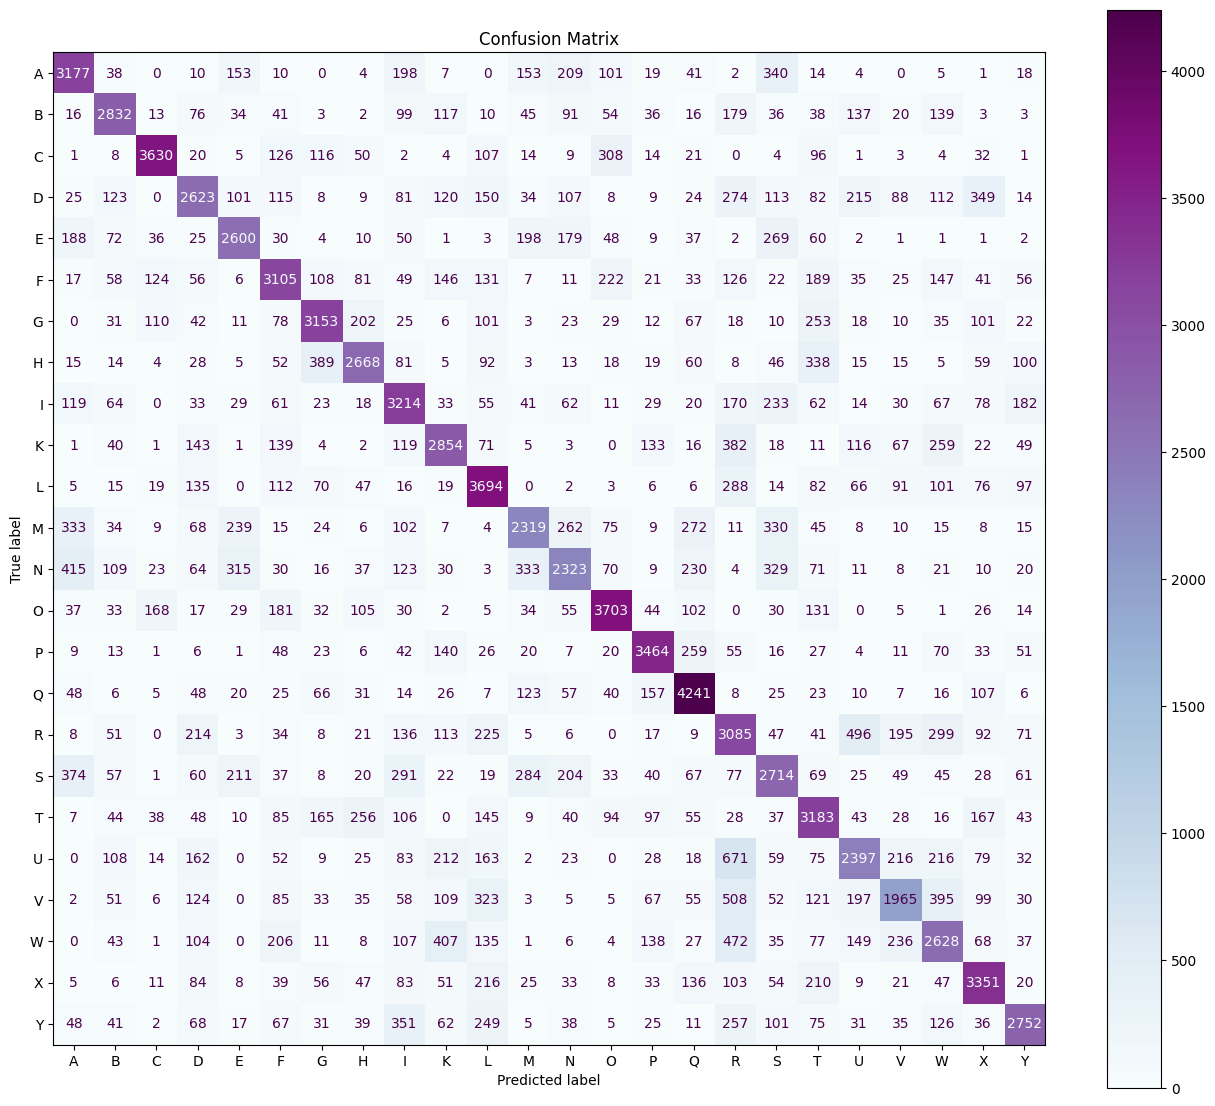

In [ ]:
evaluate_model(y_train_encoded, y_pred_xgb_train, letters)

In [ ]:
# applying xgb on Test data
y_pred_xgb_test = xgb.predict(X_test_lda)

Accuracy: 0.4844534300055772
Classification report:
              precision    recall  f1-score   support

           A       0.48      0.68      0.56      1324
           B       0.71      0.54      0.61      1728
           C       0.82      0.69      0.75      1240
           D       0.41      0.46      0.43       980
           E       0.71      0.56      0.63      1992
           F       0.46      0.50      0.48       988
           G       0.52      0.50      0.51      1392
           H       0.79      0.52      0.62      1744
           I       0.40      0.46      0.43      1152
           K       0.43      0.42      0.42      1324
           L       0.50      0.80      0.61       836
           M       0.51      0.37      0.43      1576
           N       0.35      0.29      0.32      1164
           O       0.64      0.61      0.63       984
           P       0.81      0.66      0.73      1388
           Q       0.39      0.73      0.51       656
           R       0.12      

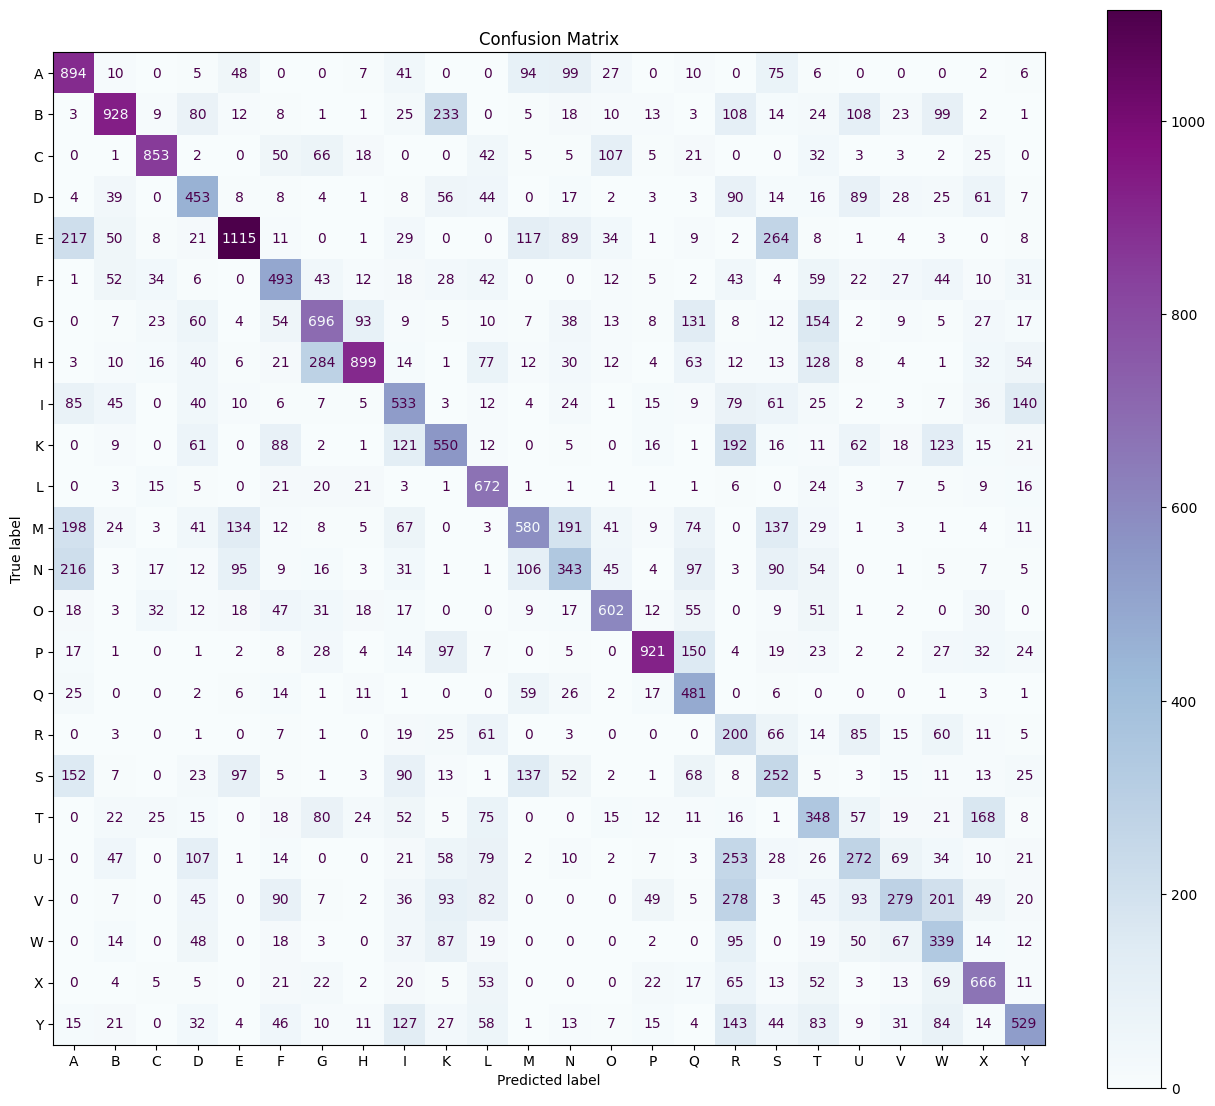

In [ ]:
evaluate_model(y_test_encoded, y_pred_xgb_test, letters)

In [ ]:
# Create an XGBoost classifier object
xgb_model = xgb.XGBClassifier()

# Create a RandomizedSearchCV object
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, verbose=3)

In [ ]:
# Fit the RandomizedSearchCV object to the transformed data
xgb_random.fit(X_train_lda, y_train)

In [ ]:
#dumping randomized search cv into pickle file 
with open('/content/svm_randomized_search_cv.pkl','wb') as f:
  pickle.dump(search_lda,f)

In [ ]:
# Get the best hyperparameters
print(xgb_random.best_params_)

# Train the XGBoost classifier with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**xgb_random.best_params_)
best_xgb_model.fit(X_train_lda, y_train)

# Predict on the test set
y_pred = best_xgb_model.predict(X_test_lda)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))

The best performing model has the following parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389473684210527}. 

In [ ]:
#display randomized search results 
pd.DataFrame(search_lda.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,48.857509,9.203732,33.812733,6.307010,sigmoid,scale,5.793684,"{'kernel': 'sigmoid', 'gamma': 'scale', 'C': 5...",0.264342,0.263249,0.498998,0.639501,0.650337,0.463285,0.171411,9
1,76.664910,13.098485,31.117175,6.553151,rbf,auto,2.638947,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389...",0.455290,0.449827,0.735567,0.998634,0.999363,0.727736,0.244413,1
2,389.728341,100.206102,19.843529,4.238948,linear,scale,8.422632,"{'kernel': 'linear', 'gamma': 'scale', 'C': 8....",0.375159,0.373611,0.687762,0.979785,0.983610,0.679985,0.271629,7
3,55.835585,8.530003,37.986475,4.330063,sigmoid,auto,6.319474,"{'kernel': 'sigmoid', 'gamma': 'auto', 'C': 6....",0.242943,0.235840,0.428884,0.547897,0.556183,0.402349,0.140491,10
4,67.057497,13.646386,28.560697,6.103911,rbf,scale,6.319474,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 6.319...",0.453014,0.448825,0.729375,0.998634,0.999180,0.725806,0.245078,2
5,56.344728,10.570659,21.329634,3.880433,linear,auto,0.01,"{'kernel': 'linear', 'gamma': 'auto', 'C': 0.01}",0.371517,0.374158,0.685850,0.979148,0.983427,0.678820,0.272135,8
6,79.955754,14.662078,18.531889,3.737042,poly,scale,3.164737,"{'kernel': 'poly', 'gamma': 'scale', 'C': 3.16...",0.385813,0.375706,0.697778,0.996449,0.996540,0.690457,0.275408,5
7,69.335164,14.177742,17.142364,3.582695,poly,auto,6.319474,"{'kernel': 'poly', 'gamma': 'auto', 'C': 6.319...",0.408213,0.407212,0.708614,0.998452,0.997632,0.704025,0.264014,3
8,81.570674,19.579337,19.994627,4.010486,linear,scale,0.535789,"{'kernel': 'linear', 'gamma': 'scale', 'C': 0....",0.375159,0.374249,0.687489,0.979785,0.983883,0.680113,0.271545,6
9,72.130835,14.146909,17.620427,3.770095,poly,scale,9.474211,"{'kernel': 'poly', 'gamma': 'scale', 'C': 9.47...",0.401930,0.401930,0.707521,0.997997,0.997906,0.701457,0.266566,4


In [ ]:
#best model
search_lda.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389473684210527}

In [ ]:
#define svm with best parameters
svm = SVC(kernel = 'rbf', gamma = 'auto', C = 2.6389473684210527)
#fit on training data 
svm.fit(X_train_lda,y_train)
#predict on training data 
y_pred_train = svm.predict(X_train_lda)
#predict on testing data
y_pred_test = svm.predict(X_test_lda)

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      2252
         1.0       0.83      0.90      0.86      2020
         2.0       0.97      0.95      0.96      2288
         3.0       0.83      0.83      0.83      2392
         4.0       0.87      0.87      0.87      1914
         5.0       0.89      0.88      0.89      2408
         6.0       0.92      0.89      0.91      2180
         7.0       0.92      0.89      0.90      2026
         8.0       0.80      0.86      0.83      2324
        10.0       0.86      0.85      0.86      2228
        11.0       0.87      0.89      0.88      2482
        12.0       0.87      0.82      0.85      2110
        13.0       0.86      0.85      0.85      2302
        14.0       0.95      0.95      0.95      2392
        15.0       0.96      0.95      0.95      2176
        16.0       0.96      0.96      0.96      2558
        17.0       0.75      0.80      0.78      2588
        18.0       0.84    

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57       662
         1.0       0.65      0.63      0.64       864
         2.0       0.78      0.78      0.78       620
         3.0       0.45      0.56      0.50       490
         4.0       0.65      0.54      0.59       996
         5.0       0.47      0.65      0.55       494
         6.0       0.56      0.45      0.50       696
         7.0       0.80      0.56      0.66       872
         8.0       0.38      0.40      0.39       576
        10.0       0.50      0.47      0.48       662
        11.0       0.52      0.66      0.58       418
        12.0       0.50      0.32      0.39       788
        13.0       0.32      0.28      0.30       582
        14.0       0.65      0.50      0.57       492
        15.0       0.64      0.57      0.60       694
        16.0       0.38      0.72      0.50       328
        17.0       0.08      0.19      0.11       288
        18.0       0.21    

In [ ]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v2.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [ ]:
#dump lda model into pickle 
with open('/content/drive/Shareddrives/SignLanguageData/pickle_project_content/lda_100k_aug.pkl','wb') as f:
  pickle.dump(lda,file=f)

In [ ]:
#dumping into pickle 
svm_content = (svm,y_pred_train,y_pred_test)
with open('/content/drive/Shareddrives/SignLanguageData/SVMModel_TrainTestPredictions.pkl','wb') as f:
  pickle.dump(svm_content,file=f)

Letter R performs significantly worse than the other letters. Inspecting R examples directly. 

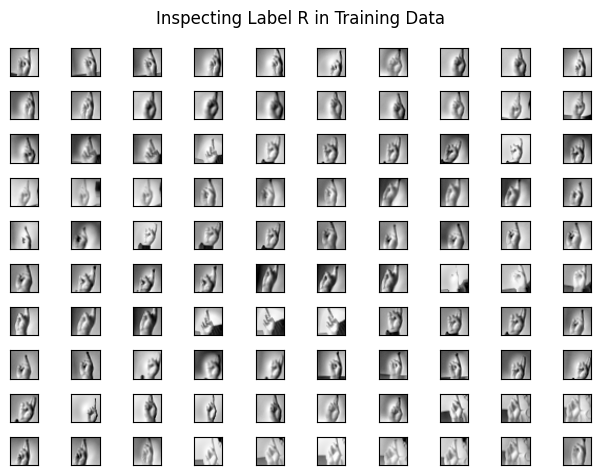

In [ ]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

#visualization of dataset 
fig, ax = plt.subplots(10,10)
plt.suptitle('Inspecting Label R in Training Data')
ax = ax.ravel()
pos = 0 

label = 17

index = find_indices(y_train,label)[0]

#loop through each label in dataset 
for i, idx in enumerate(index):
    if i >= 100:
        break
    #display first found image 
    ax[pos].imshow(X_train[idx].reshape(28,28),cmap='gray')
    #do not show ticks 
    ax[pos].set_xticks([])
    ax[pos].set_yticks([])
    #increment for subplotting 
    pos+=1

plt.tight_layout()
plt.show()

RandomizedGridSearch on combined lda/pca 53 features

In [32]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')
#unpacking 
X_train = data['X_train']
y_train = data['y_train'].astype(int)
X_test = data['X_test']
y_test = data['y_test'].astype(int)
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [34]:
#function for sampling
def sampler(X,y,num_sample):
  indices = np.random.choice(X.shape[0], num_sample, replace=False)
  return X[indices,:],y[indices]

#sampling
X_train_sample,y_train_sample = sampler(X_train,y_train_encoded,50000)
X_test_sample,y_test_sample = sampler(X_test,y_test_encoded,15000)

In [35]:
# define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.3, 0.5, 0.8],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 6, 10, 15],
    'subsample': [0.4, 0.6],
    'colsample_bytree': [0.4, 0.6],
    'gamma': [0],
    'reg_alpha': [0,.25,.5,.8,1.5,2],
    'reg_lambda': [1,1.25,1.5,1.75,2]
}

In [36]:
# Create an XGBoost classifier object
xgb_model = xgb.XGBClassifier()

# Create a RandomizedSearchCV object
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, random_state=42, verbose=3)

In [37]:
#fitting to combined lda, pca 53 features 
xgb_random.fit(X_train_sample,y_train_sample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=3, reg_alpha=0.25, reg_lambda=1, subsample=0.4;, score=0.814 total time= 6.1min
[CV 2/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=3, reg_alpha=0.25, reg_lambda=1, subsample=0.4;, score=0.818 total time= 6.1min
[CV 3/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=3, reg_alpha=0.25, reg_lambda=1, subsample=0.4;, score=0.813 total time= 6.0min
[CV 4/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=3, reg_alpha=0.25, reg_lambda=1, subsample=0.4;, score=0.816 total time= 6.1min
[CV 5/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=3, reg_alpha=0.25, reg_lambda=1, subsample=0.4;, score=0.807 total time= 6.4min
[CV 1/5] END colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_d

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.4, 0.6],
                                        'gamma': [0],
                                        'learning_rate': [0.01, 0.3, 0.5, 0.8],
                                        'max_depth': [3, 4, 5, 6, 8],
                                        'min_child_weight': [1, 3, 6, 10, 15],
                                        'reg_alpha': [0, 0.25, 0.5, 0.8, 1.5,
                                                      2],
                                        'reg_lambda': [1, 1.25, 1.5, 1.75, 2],
                                        'subsample': [0.4, 0.6]},
                   random_state=42, verbose=3)

In [38]:
import pickle

with open('/content/drive/Shareddrives/SignLanguageData/XGB_LDAPCA_RCV.pkl','wb') as f:
  pickle.dump(xgb_random,f)

In [4]:
import pickle

with open('/content/drive/Shareddrives/SignLanguageData/XGB_LDAPCA_RCV.pkl','rb') as f:
  xgb_random = pickle.load(f)

In [7]:
xgb_random.best_params_

{'subsample': 0.4,
 'reg_lambda': 1.75,
 'reg_alpha': 1.5,
 'min_child_weight': 10,
 'max_depth': 8,
 'learning_rate': 0.5,
 'gamma': 0,
 'colsample_bytree': 0.4}

In [3]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')
#unpacking 
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [13]:
# Create an XGBoost classifier object
xgb_model = xgb.XGBClassifier(subsample=0.4,reg_lambda=1.75,reg_alpha=1.5,min_child_weight=10,max_depth=8,learning_rate=0.5,gamma=0,colsample_bytree=0.4)

xgb_model.fit(X_train,y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [14]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [15]:
print(classification_report(y_train_encoded,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4504
           1       1.00      1.00      1.00      4040
           2       1.00      1.00      1.00      4576
           3       1.00      1.00      1.00      4784
           4       1.00      1.00      1.00      3828
           5       1.00      1.00      1.00      4816
           6       1.00      1.00      1.00      4360
           7       1.00      1.00      1.00      4052
           8       1.00      1.00      1.00      4648
           9       1.00      1.00      1.00      4456
          10       1.00      1.00      1.00      4964
          11       1.00      1.00      1.00      4220
          12       1.00      1.00      1.00      4604
          13       1.00      1.00      1.00      4784
          14       1.00      1.00      1.00      4352
          15       1.00      1.00      1.00      5116
          16       1.00      1.00      1.00      5176
          17       1.00    

In [16]:
print(classification_report(y_test_encoded,y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1324
           1       0.95      0.83      0.88      1728
           2       0.94      0.90      0.92      1240
           3       0.78      0.86      0.82       980
           4       0.88      0.85      0.86      1992
           5       0.87      0.93      0.90       988
           6       0.90      0.84      0.87      1392
           7       0.92      0.91      0.92      1744
           8       0.86      0.84      0.85      1152
           9       0.80      0.82      0.81      1324
          10       0.91      0.97      0.94       836
          11       0.78      0.71      0.74      1576
          12       0.65      0.70      0.68      1164
          13       0.89      0.86      0.87       984
          14       0.98      0.96      0.97      1388
          15       0.90      0.96      0.93       656
          16       0.47      0.68      0.55       576
          17       0.59    

In [33]:
# Create an XGBoost classifier object
xgb_model = xgb.XGBClassifier(subsample=0.4,reg_lambda=2.25,reg_alpha=2,min_child_weight=30,max_depth=8,learning_rate=0.001,gamma=0,colsample_bytree=0.4)

xgb_model.fit(X_train,y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=30, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [34]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [35]:
print(classification_report(y_train_encoded,y_pred_train))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      4504
           1       0.85      0.77      0.81      4040
           2       0.92      0.83      0.87      4576
           3       0.74      0.65      0.69      4784
           4       0.82      0.69      0.75      3828
           5       0.84      0.81      0.82      4816
           6       0.80      0.83      0.82      4360
           7       0.77      0.77      0.77      4052
           8       0.74      0.76      0.75      4648
           9       0.73      0.68      0.71      4456
          10       0.81      0.85      0.83      4964
          11       0.75      0.61      0.68      4220
          12       0.72      0.64      0.68      4604
          13       0.82      0.84      0.83      4784
          14       0.88      0.90      0.89      4352
          15       0.82      0.91      0.86      5116
          16       0.61      0.76      0.68      5176
          17       0.64    

In [36]:
print(classification_report(y_test_encoded,y_pred_test))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66      1324
           1       0.82      0.56      0.67      1728
           2       0.91      0.73      0.81      1240
           3       0.53      0.53      0.53       980
           4       0.81      0.61      0.69      1992
           5       0.68      0.70      0.69       988
           6       0.67      0.67      0.67      1392
           7       0.79      0.69      0.74      1744
           8       0.61      0.59      0.60      1152
           9       0.51      0.51      0.51      1324
          10       0.67      0.87      0.76       836
          11       0.59      0.41      0.48      1576
          12       0.45      0.37      0.41      1164
          13       0.67      0.70      0.69       984
          14       0.91      0.86      0.88      1388
          15       0.58      0.87      0.70       656
          16       0.18      0.48      0.27       576
          17       0.30    

In [46]:
with open('/content/drive/Shareddrives/SignLanguageData/FinalXGB.pkl','wb') as f:
  pickle.dump(xgb_model,f)

In [47]:
def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap='BuPu', ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.759278819887088
Classification report:
              precision    recall  f1-score   support

           A       0.70      0.81      0.75      4504
           B       0.85      0.77      0.81      4040
           C       0.92      0.83      0.87      4576
           D       0.74      0.65      0.69      4784
           E       0.82      0.69      0.75      3828
           F       0.84      0.81      0.82      4816
           G       0.80      0.83      0.82      4360
           H       0.77      0.77      0.77      4052
           I       0.74      0.76      0.75      4648
           K       0.73      0.68      0.71      4456
           L       0.81      0.85      0.83      4964
           M       0.75      0.61      0.68      4220
           N       0.72      0.64      0.68      4604
           O       0.82      0.84      0.83      4784
           P       0.88      0.90      0.89      4352
           Q       0.82      0.91      0.86      5116
           R       0.61      0

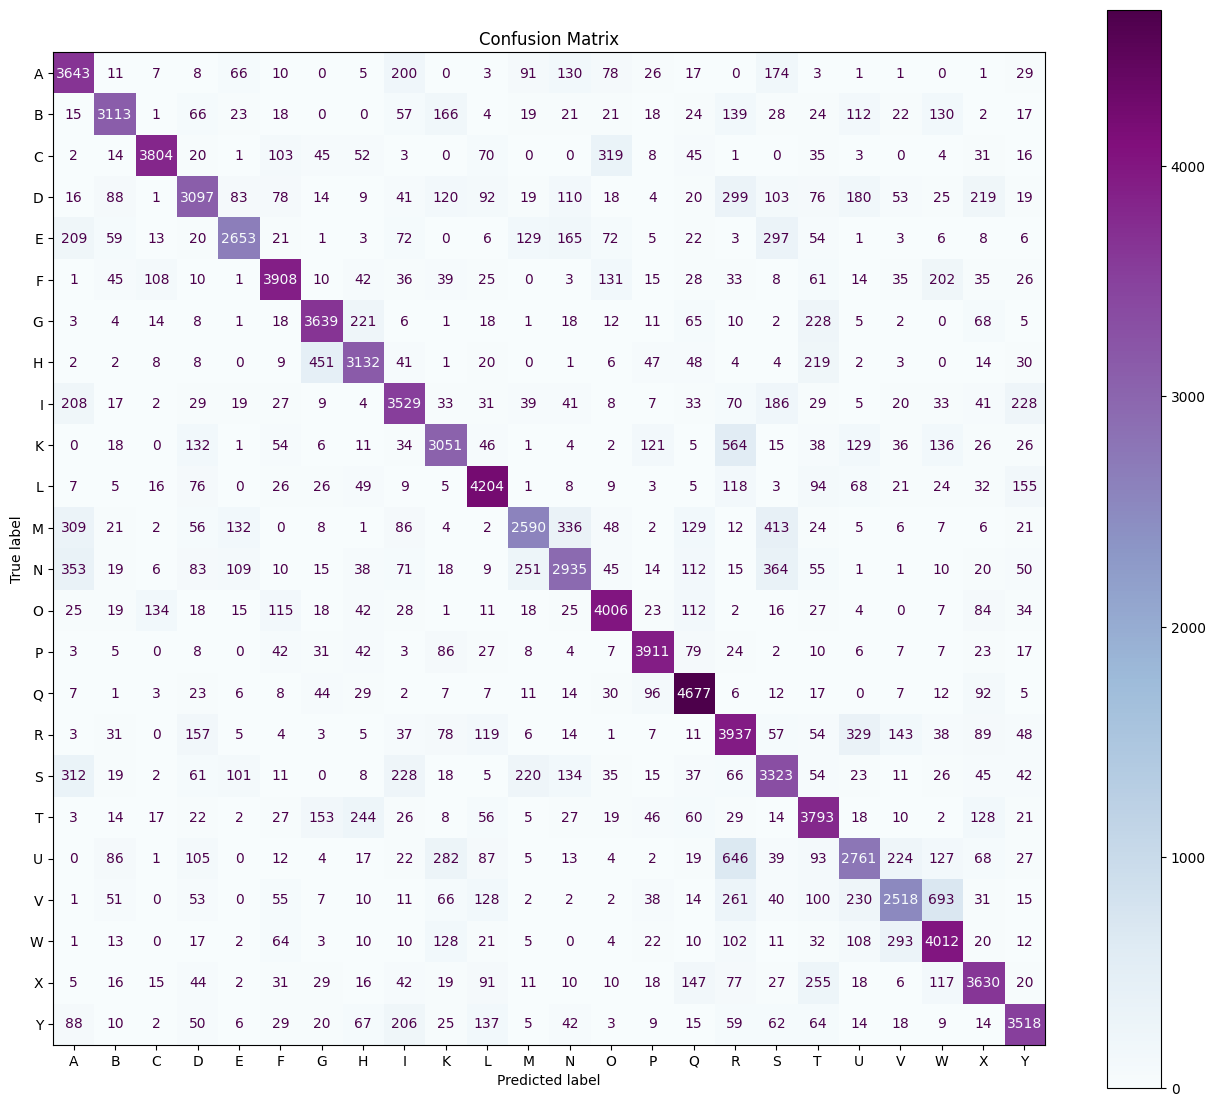

In [48]:
evaluate_model(y_train_encoded,y_pred_train,letters)

Accuracy: 0.5957543223647518
Classification report:
              precision    recall  f1-score   support

           A       0.57      0.78      0.66      1324
           B       0.82      0.56      0.67      1728
           C       0.91      0.73      0.81      1240
           D       0.53      0.53      0.53       980
           E       0.81      0.61      0.69      1992
           F       0.68      0.70      0.69       988
           G       0.67      0.67      0.67      1392
           H       0.79      0.69      0.74      1744
           I       0.61      0.59      0.60      1152
           K       0.51      0.51      0.51      1324
           L       0.67      0.87      0.76       836
           M       0.59      0.41      0.48      1576
           N       0.45      0.37      0.41      1164
           O       0.67      0.70      0.69       984
           P       0.91      0.86      0.88      1388
           Q       0.58      0.87      0.70       656
           R       0.18      

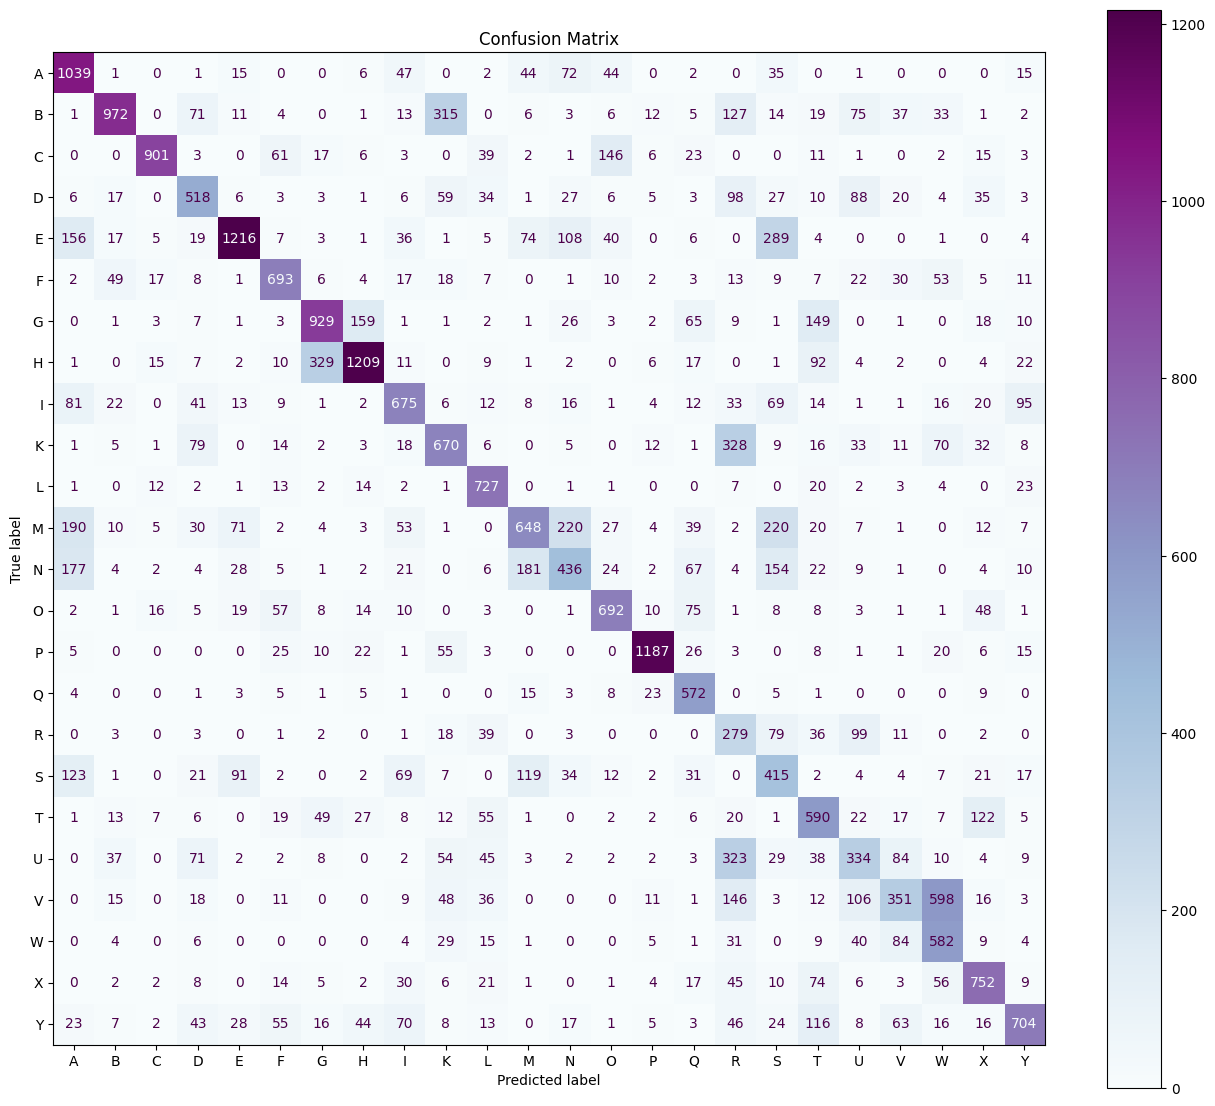

In [49]:
evaluate_model(y_test_encoded,y_pred_test,letters)

In [44]:
from sklearn.metrics import roc_curve,auc
from matplotlib.pyplot import cm

def plot_roc_curve(classifiers, X_train, y_train):
    n_classes = len(np.unique(y_train))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train == i, classifiers.predict_proba(X_train)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = cm.tab20(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

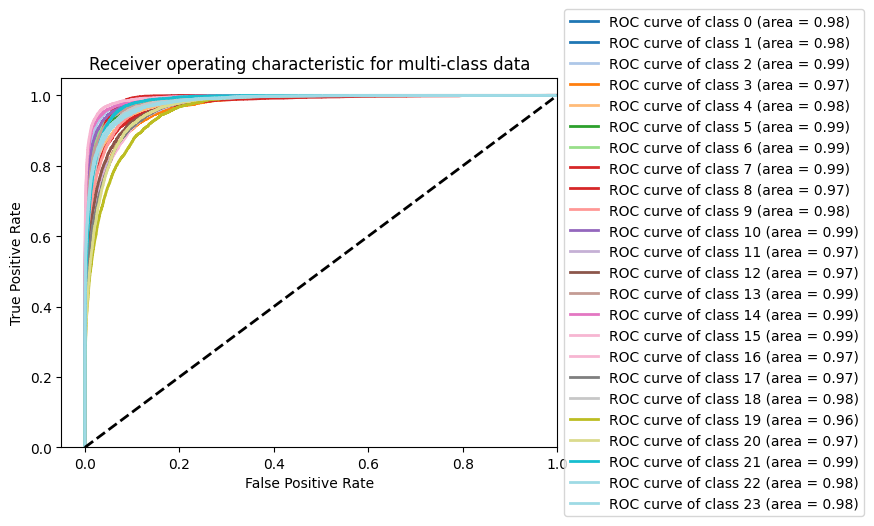

In [50]:
plot_roc_curve(xgb_model,X_train,y_train_encoded)

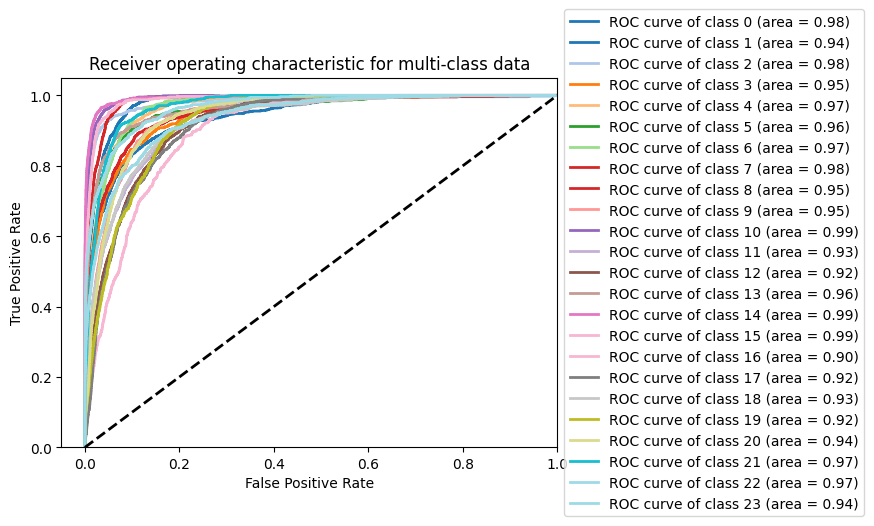

In [51]:
plot_roc_curve(xgb_model,X_test,y_test_encoded)